# Downloading dataset from kaggle

StyleGAN & Flickr for training and validation

In [28]:
import kagglehub
import shutil
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Specify the desired download path
download_path = "/content/dataset"

# Create the destination directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset (initially downloaded to Kaggle cache)
cache_path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Path to dataset files (cache):", cache_path)  # 'cache_path' points to the cache


Path to dataset files (cache): /kaggle/input/140k-real-and-fake-faces


In [29]:
# Define source (Kaggle cache) and destination paths
source_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake'  # Adjust if version changes
destination_path = download_path

# Iterate over all items in the source directory and copy them
for item in os.listdir(source_path):
    src_item = os.path.join(source_path, item)
    dst_item = os.path.join(destination_path, item)

    # If item is a directory, use shutil.copytree, else use shutil.copy2
    if os.path.isdir(src_item):
        shutil.copytree(src_item, dst_item)
    else:
        shutil.copy2(src_item, dst_item)  # copy2 preserves metadata

print(f"Files copied from '{source_path}' to '{destination_path}' successfully.")

Files copied from '/kaggle/input/140k-real-and-fake-faces/real_vs_fake' to '/content/dataset' successfully.


PRO-GAN dataset for testing

In [30]:
import kagglehub
import os
from torchvision import datasets

# Download latest version
path = kagglehub.dataset_download("mayankjha146025/fake-face-images-generated-from-different-gans")
print("Path to dataset files:", path)

# Check if the dataset contains an 'images' folder
# If not, adjust the folder name accordingly
if not os.path.exists(os.path.join(path, 'images')):
    # List all folders in the dataset path
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    if folders:
        # Assume the first folder in the list is the correct one
        image_folder_path = os.path.join(path, folders[0])
    else:
        raise FileNotFoundError("No subfolders found in the dataset directory.")
else:
    image_folder_path = os.path.join(path, 'images')

# Create an ImageFolder dataset object to easily access the data
dataset = datasets.ImageFolder(image_folder_path)

# Print the total number of samples in the dataset
print("Total number of data samples:", len(dataset))

Path to dataset files: /kaggle/input/fake-face-images-generated-from-different-gans
Total number of data samples: 21300


Swap the testing folder to test with PROGAN

In [31]:
import os
import shutil
import random

# 1. Delete content in /content/dataset/real_vs_fake/test/fake
fake_folder = '/content/dataset/real_vs_fake/test/fake'
for filename in os.listdir(fake_folder):
    file_path = os.path.join(fake_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# 2. Randomly delete 2100 images from /content/dataset/real_vs_fake/real-vs-fake/test/real
real_folder = '/content/dataset/real_vs_fake/test/real'
real_images = os.listdir(real_folder)
images_to_delete = random.sample(real_images, 2900)
for image in images_to_delete:
    image_path = os.path.join(real_folder, image)
    os.remove(image_path)

# 3. Move images from /content/fake-face-images-generated-from-different-gans/GAN_Generated_Fake_Images/ProGAN_128x128 to /content/dataset/real_vs_fake/real-vs-fake/test/fake
source_folder = '/kaggle/input/fake-face-images-generated-from-different-gans/GAN_Generated_Fake_Images/ProGAN_128x128'
for filename in os.listdir(source_folder):
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(fake_folder, filename)
    # Use shutil.copy instead of shutil.move
    shutil.copy(source_path, destination_path)

print("Operations completed successfully.")

Operations completed successfully.


# Data Loading and Augmentation

In [24]:

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [25]:
def check_data_quantity(dataset, dataset_name):
    print(f"Dataset: {dataset_name}")
    print(f"  Total samples: {len(dataset)}")
    # If the dataset is an instance of ImageFolder, it contains a 'targets' attribute.
    if hasattr(dataset, 'targets'):
        from collections import Counter
        counts = Counter(dataset.targets)
        # Map numeric labels back to class names using class_to_idx
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
        print("  Class distribution:")
        for cls, count in counts.items():
            print(f"    {idx_to_class[cls]}: {count}")
    else:
        print("  No target information available.")



In [26]:

import torch.nn.functional as F # For contrastive loss / cosine similarity
import torch.fft # For Frequency Pathway

# Define the target size (consistent with your model's FC layer)
IMAGE_SIZE = 256

# Define data transforms
# Standard transforms for training
train_transforms_standard = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Less aggressive jitter for main view
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

# Stronger augmentation for contrastive learning view
train_transforms_contrastive = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # Slightly more rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.1), # Stronger jitter
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=int(0.1 * IMAGE_SIZE) // 2 * 2 + 1, sigma=(0.1, 2.0)), # Add blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

# Transforms for validation/testing (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

class ContrastiveImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform1, transform2, **kwargs):
        super().__init__(root, transform=None, **kwargs) # Initial transform is None
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        # Apply the two different transforms
        img1 = self.transform1(sample)
        img2 = self.transform2(sample)
        return img1, img2, target # Return two views and the label


# --- Load or Create Datasets ---
train_data_path = 'preprocessed_train_data_contrastive.pt' # Use new names
val_data_path = 'preprocessed_val_data.pt'
test_data_path = 'preprocessed_test_data.pt'

if os.path.exists(train_data_path) and os.path.exists(val_data_path) and os.path.exists(test_data_path):

    print("Re-creating datasets for contrastive setup...")
    train_data = ContrastiveImageFolder('/content/dataset/real_vs_fake/train', transform1=train_transforms_standard, transform2=train_transforms_contrastive)
    val_data = datasets.ImageFolder('/content/dataset/real_vs_fake/valid', transform=val_test_transforms)
    test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/test', transform=val_test_transforms)
else:
    print("Creating datasets for contrastive setup...")
    train_data = ContrastiveImageFolder('/content/dataset/real_vs_fake/train', transform1=train_transforms_standard, transform2=train_transforms_contrastive)
    val_data = datasets.ImageFolder('/content/dataset/real_vs_fake/valid', transform=val_test_transforms)
    test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/test', transform=val_test_transforms)


# --- Re-define the DataLoaders ---
batch_size = 64 # Adjusted batch size maybe needed due to memory
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Check data quantity
check_data_quantity(train_data, "Train (Contrastive)")
check_data_quantity(val_data, "Validation")
check_data_quantity(test_data, "Test")

Creating datasets for contrastive setup...
Dataset: Train (Contrastive)
  Total samples: 100000
  Class distribution:
    fake: 50000
    real: 50000
Dataset: Validation
  Total samples: 20000
  Class distribution:
    fake: 10000
    real: 10000
Dataset: Test
  Total samples: 11300
  Class distribution:
    fake: 7100
    real: 4200


In [8]:
# Get a sample from the training dataset to check the shape after transforms
print("Checking shape of a sample image pair after preprocessing:")
# Retrieve the first sample (two image tensors and label) from the train_data
sample_image_tensor1, sample_image_tensor2, sample_label = train_data[0]

print(f"  Type of the preprocessed image view 1: {type(sample_image_tensor1)}")
print(f"  Shape of the preprocessed image view 1 (C, H, W): {sample_image_tensor1.shape}")
print(f"  Type of the preprocessed image view 2: {type(sample_image_tensor2)}")
print(f"  Shape of the preprocessed image view 2 (C, H, W): {sample_image_tensor2.shape}")
print(f"  Label of the sample: {sample_label} (Class: {train_data.classes[sample_label]})")

# Check the shape of a batch from the DataLoader
print("\nChecking shape of a batch from the DataLoader:")
# Get one batch of data from the train_loader
images1_batch, images2_batch, labels_batch = next(iter(train_loader))
print(f"  Shape of image batch view 1 (B, C, H, W): {images1_batch.shape}")
print(f"  Shape of image batch view 2 (B, C, H, W): {images2_batch.shape}")
print(f"  Shape of a label batch (B): {labels_batch.shape}")


Checking shape of a sample image pair after preprocessing:
  Type of the preprocessed image view 1: <class 'torch.Tensor'>
  Shape of the preprocessed image view 1 (C, H, W): torch.Size([3, 256, 256])
  Type of the preprocessed image view 2: <class 'torch.Tensor'>
  Shape of the preprocessed image view 2 (C, H, W): torch.Size([3, 256, 256])
  Label of the sample: 0 (Class: fake)

Checking shape of a batch from the DataLoader:
  Shape of image batch view 1 (B, C, H, W): torch.Size([64, 3, 256, 256])
  Shape of image batch view 2 (B, C, H, W): torch.Size([64, 3, 256, 256])
  Shape of a label batch (B): torch.Size([64])


In [9]:
# Get a sample from the test dataset to check the shape after transforms
print("\nChecking shape of a sample TEST image after preprocessing:")
# Retrieve the first sample (image tensor and its label) from the test_data
sample_test_image_tensor, sample_test_label = test_data[0]

print(f"  Type of the preprocessed test image: {type(sample_test_image_tensor)}")
print(f"  Shape of the preprocessed test image (Channels, Height, Width): {sample_test_image_tensor.shape}")
print(f"  Label of the test sample: {sample_test_label} (Class: {test_data.classes[sample_test_label]})") # Optional: see label

# You can also check the shape of a batch from the test DataLoader
print("\nChecking shape of a batch from the TEST DataLoader:")
# Get one batch of data from the test_loader
test_images_batch, test_labels_batch = next(iter(test_loader))
print(f"  Shape of a test image batch (Batch Size, Channels, Height, Width): {test_images_batch.shape}")
print(f"  Shape of a test label batch (Batch Size): {test_labels_batch.shape}") # Optional: see labels shape


Checking shape of a sample TEST image after preprocessing:
  Type of the preprocessed test image: <class 'torch.Tensor'>
  Shape of the preprocessed test image (Channels, Height, Width): torch.Size([3, 256, 256])
  Label of the test sample: 0 (Class: fake)

Checking shape of a batch from the TEST DataLoader:
  Shape of a test image batch (Batch Size, Channels, Height, Width): torch.Size([64, 3, 256, 256])
  Shape of a test label batch (Batch Size): torch.Size([64])


# First-Level Disentanglement: DR-GAN Module

In [ ]:
from torchvision import models

# @inproceedings{tran2017drgan,
#   title={Disentangled representation learning gan for pose-invariant face recognition},
#   author={Tran, Luan and Yin, Xi and Liu, Xiaoming},
#   booktitle={Proceedings of the IEEE conference on computer vision and pattern recognition (CVPR)},
#   pages={1415--1424},
#   year={2017}
# }

class DRGANEncoder(nn.Module):
    def __init__(self, latent_dim=128, freeze_backbone=True):
        super(DRGANEncoder, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False
        num_ftrs = backbone.fc.in_features
        self.fc = nn.Linear(num_ftrs, latent_dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # Flatten features
        latent = self.fc(x)
        return latent

class DRGANDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(DRGANDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512*16*16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16->32
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32->64
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64->128
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 128->256
            nn.Tanh()
        )

    def forward(self, latent):
        x = self.fc(latent)
        x = x.view(x.size(0), 512, 16, 16)
        rec = self.deconv(x)
        return rec

class DRGAN(nn.Module):
    def __init__(self, latent_dim=128):
        super(DRGAN, self).__init__()
        self.encoder = DRGANEncoder(latent_dim=latent_dim)
        self.decoder = DRGANDecoder(latent_dim=latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2)  # 2 classes: real, fake
        )

    def forward(self, x):
        latent = self.encoder(x)
        rec = self.decoder(latent)
        class_logits = self.classifier(latent)
        return latent, rec, class_logits


#  Second-Level Analysis: Multi-Pathway Modules

In [11]:

class SemanticPathway(nn.Module):
    def __init__(self, in_dim=128, out_dim=64):
        super(SemanticPathway, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, latent):
        return self.net(latent)

class FrequencyPathway(nn.Module):
    def __init__(self, image_size=256, out_dim=64):
        super(FrequencyPathway, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        fft_flat_dim = 8 * 8 # Size after pooling

        self.net = nn.Sequential(
            nn.Linear(fft_flat_dim, 128), # Intermediate layer
            nn.ReLU(inplace=True),
            nn.Linear(128, out_dim)
        )

    def forward(self, image):
        # Input image shape: (B, C, H, W)
        # Compute 2D real FFT
        fft_coeffs = torch.fft.rfft2(image, norm="ortho")
        # Compute magnitude (abs)
        fft_mag = torch.abs(fft_coeffs) # Shape: (B, C, H, W//2 + 1)

        # Average magnitude across channels
        fft_mag_pooled_channel = fft_mag.mean(dim=1, keepdim=True) # Shape: (B, 1, H, W//2 + 1)

        # Apply adaptive average pooling to reduce spatial dimensions
        pooled_fft_mag = self.pool(fft_mag_pooled_channel) # Shape: (B, 1, 8, 8)

        # Flatten and pass through MLP
        flat_fft = torch.flatten(pooled_fft_mag, 1) # Shape: (B, 64)
        return self.net(flat_fft)

class BiologicalPathway(nn.Module):
    def __init__(self, in_dim=128, out_dim=64):
        super(BiologicalPathway, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, latent):
        return self.net(latent)


# Contrastive Refinement Layer

In [ ]:
# @misc{oord2018cpc,
#       title={Representation Learning with Contrastive Predictive Coding},
#       author={Aaron van den Oord and Yazhe Li and Oriol Vinyals},
#       year={2018},
#       eprint={1807.03748},
#       archivePrefix={arXiv},
#       primaryClass={cs.LG}
# }

class ContrastiveRefinement(nn.Module):
    def __init__(self, in_dim=128, out_dim=64): # out_dim is the projection dimension
        super(ContrastiveRefinement, self).__init__()
        # Projector head for contrastive learning (e.g., MLP)
        self.projector = nn.Sequential(
            nn.Linear(in_dim, in_dim // 2), # Intermediate layer
            nn.ReLU(inplace=True),
            nn.Linear(in_dim // 2, out_dim)
            # No normalization here, will do in loss calculation
        )

    def forward(self, latent):
        # Project latent representation into contrastive space.
        projection = self.projector(latent)
        return projection

# Adversarial Equilibrium Component (NashAE-Inspired)

In [ ]:
# @misc{arxivNashAEDisentangling,
# 	author = {},
# 	title = {{N}ash{A}{E}: {D}isentangling {R}epresentations through {A}dversarial {C}ovariance {M}inimization --- arxiv.org},
# 	howpublished = {\url{https://arxiv.org/abs/2209.10677}},
# 	year = {},
# }
class NashAE(nn.Module):
    def __init__(self, in_dim=128, latent_dim=64):
        super(NashAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, latent_dim),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, in_dim),
            nn.ReLU(inplace=True)
        )
        # Discriminator to enforce a prior (e.g. sparse latent space)
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, latent):
        z = self.encoder(latent)
        rec = self.decoder(z)
        d_score = self.discriminator(z)
        return z, rec, d_score


# Decision Fusion Mechanism

In [14]:
class DecisionFusion(nn.Module):
    def __init__(self, in_dims=[64, 64, 64, 64, 64], hidden_dim=64, out_dim=2):
        super(DecisionFusion, self).__init__()
        num_pathways = len(in_dims)
        total_in_dim = sum(in_dims)

        # Learnable weights for each pathway
        self.pathway_weights = nn.Parameter(torch.ones(num_pathways))

        # Fusion MLP
        self.fc = nn.Sequential(
            nn.Linear(total_in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, semantic, frequency, biological, contrastive, nash):
        features = [semantic, frequency, biological, contrastive, nash]
        batch_size = features[0].size(0)

        normalized_weights = F.softmax(self.pathway_weights, dim=0)

        weighted_features = []
        for i, feat in enumerate(features):
            weight = normalized_weights[i].view(1, 1).expand(batch_size, 1)
            weighted_features.append(feat * weight.expand_as(feat))

        # Concatenate weighted features
        fused_features = torch.cat(weighted_features, dim=1)

        # Final classification
        return self.fc(fused_features)

    def get_weights(self):
        # Helper to check learned weights
        return F.softmax(self.pathway_weights, dim=0)

# Assemble the Full Hierarchical Disentanglement Ensemble (HDE)

In [15]:
class HDE(nn.Module):
    def __init__(self, latent_dim=128, image_size=256): # Added image_size
        super(HDE, self).__init__()
        # First-level disentanglement via DR-GAN
        self.drgan = DRGAN(latent_dim=latent_dim)

        # Second-level analysis: pathways
        self.semantic = SemanticPathway(in_dim=latent_dim, out_dim=64)
        # Frequency pathway
        self.frequency = FrequencyPathway(image_size=image_size, out_dim=64)
        self.biological = BiologicalPathway(in_dim=latent_dim, out_dim=64)

        # Contrastive refinement (projection head)
        self.contrastive = ContrastiveRefinement(in_dim=latent_dim, out_dim=64)

        # Adversarial equilibrium component (NashAE-inspired)
        self.nash = NashAE(in_dim=latent_dim, latent_dim=64)

        self.fusion = DecisionFusion(in_dims=[64, 64, 64, 64, 64], out_dim=2)

    def forward(self, x):
        # First-level: DR-GAN disentanglement
        latent, rec, class_logits = self.drgan(x)

        # Second-level: process latent and image through parallel pathways
        semantic_feat = self.semantic(latent)
        frequency_feat = self.frequency(x)
        biological_feat = self.biological(latent)

        # Contrastive projection
        contrastive_feat = self.contrastive(latent)

        # NashAE processing
        nash_z, nash_rec, nash_dscore = self.nash(latent)

        # Fusion: combine all pathways
        fused_logits = self.fusion(semantic_feat, frequency_feat, biological_feat, contrastive_feat, nash_z)

        # Return dictionary of relevant outputs
        return {
            'latent': latent,
            'drgan_rec': rec,
            'drgan_class': class_logits,
            'semantic': semantic_feat,
            'frequency': frequency_feat,
            'biological': biological_feat,
            'contrastive': contrastive_feat, # Projection for contrastive loss
            'nash_z': nash_z,
            'nash_rec': nash_rec,
            'nash_dscore': nash_dscore,
            'fused_logits': fused_logits # Final classification output
        }

    def get_contrastive_projection(self, x_aug):
         with torch.no_grad():
             latent_aug = self.drgan.encoder(x_aug)
         contrastive_feat_aug = self.contrastive(latent_aug)
         return contrastive_feat_aug

# Training and Evaluation Routines

In [ ]:
import time
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def info_nce_loss(features, temperature=0.1, device='cuda', eps=1e-7):
    """
    Calculates the InfoNCE loss for contrastive learning.
    Args:
        features: Tensor of shape (2 * batch_size, proj_dim).
                  Assumes the first half are projections from view 1 (z_i)
                  and the second half are projections from view 2 (z_j).
        temperature: Temperature scaling factor.
        device: CUDA or CPU.
        eps: Small epsilon for numerical stability.
    Returns:
        Loss tensor.
    """
    if features.shape[0] % 2 != 0:
        raise ValueError("Feature batch size must be even (view1 + view2).")

    batch_size = features.shape[0] // 2
    if batch_size == 0:
        return torch.tensor(0.0, device=device, requires_grad=True) # Return zero loss if batch is empty

    # Check for NaNs/Infs in input features BEFORE normalization
    if torch.isnan(features).any() or torch.isinf(features).any():
        print("WARNING: NaN/Inf detected in features input to info_nce_loss!")
        raise RuntimeError("NaN/Inf detected in info_nce_loss input features")

    features_normalized = F.normalize(features, dim=1, eps=eps)

    # Check for NaNs/Infs AFTER normalization
    if torch.isnan(features_normalized).any() or torch.isinf(features_normalized).any():
        print("WARNING: NaN/Inf detected in features AFTER normalization in info_nce_loss!")
        # Consider printing the norm values of the original features here if this happens
        # print("Original feature norms:", torch.norm(features, p=2, dim=1))
        raise RuntimeError("NaN/Inf detected after normalization in info_nce_loss")


    # Compute cosine similarity matrix
    similarity_matrix = torch.matmul(features_normalized, features_normalized.T) # Shape: (2B, 2B)

    # Check similarity matrix
    if torch.isnan(similarity_matrix).any() or torch.isinf(similarity_matrix).any():
         print("WARNING: NaN/Inf detected in similarity_matrix in info_nce_loss!")
         raise RuntimeError("NaN/Inf detected in similarity_matrix")


    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(device)
    # Select elements NOT on the diagonal
    similarity_matrix_masked = similarity_matrix[~mask].view(batch_size * 2, -1) # Shape: (2B, 2B-1)


    # --- Select positive pairs ---
    # Get the projections for view 1 and view 2
    z_i = features_normalized[:batch_size] # Shape: (B, D)
    z_j = features_normalized[batch_size:] # Shape: (B, D)
    # Calculate cosine similarity for positive pairs (i, j) - already normalized so just dot product
    sim_ij = torch.sum(z_i * z_j, dim=1) # Shape: (B,)


    positive_sim = torch.cat([sim_ij, sim_ij], dim=0) # Shape: (2B,)

    # Prepend the positive similarity for each anchor.
    logits = torch.cat([positive_sim.unsqueeze(1), similarity_matrix_masked], dim=1) # Shape: (2B, 2B)
    logits /= temperature

    # Check logits
    if torch.isnan(logits).any() or torch.isinf(logits).any():
         print("WARNING: NaN/Inf detected in final logits in info_nce_loss!")
         # print("Max logit:", logits[~torch.isinf(logits)].max())
         # print("Min logit:", logits[~torch.isinf(logits)].min())
         # print("Temperature:", temperature)
         raise RuntimeError("NaN/Inf detected in logits")


    # Labels for CrossEntropyLoss are all zeros because the positive pair is constructed at index 0
    ce_labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

    # Calculate CrossEntropyLoss
    loss = F.cross_entropy(logits, ce_labels)
    return loss


# --- Training Function (One Epoch) ---
def train_epoch(model, dataloader, optimizer, device, criterion_cls,
                lambda_rec=1.0, lambda_adv=0.1, lambda_ctr=0.5, contrastive_temp=0.1,
                gradient_clip_norm=1.0): # Added gradient clipping param
    model.train()
    total_loss = 0
    total_loss_cls_drgan, total_loss_cls_fusion = 0, 0
    total_loss_rec_drgan, total_loss_rec_nash = 0, 0
    total_loss_ctr, total_loss_adv = 0, 0
    start_time = time.time()

    batch_print_freq = 100 # How often to print batch progress

    for batch_idx, (imgs1, imgs2, labels) in enumerate(dataloader):
        imgs1 = imgs1.to(device) # Standard view
        imgs2 = imgs2.to(device) # Augmented view for contrastive
        labels = labels.to(device)

        # --- Label Check (Keep this) ---
        if not ((labels >= 0) & (labels < 2)).all():
            print(f"!!! ERROR: Invalid labels found in batch {batch_idx} !!!")
            print(f"Unique labels in batch: {torch.unique(labels)}")
            raise ValueError("Invalid labels detected.")
        # --- End Label Check ---

        optimizer.zero_grad()

        try:
            # --- Forward pass for main view (imgs1) ---
            outputs = model(imgs1)

            # --- Get contrastive projection for augmented view (imgs2) ---
            contrastive_feat_aug = model.get_contrastive_projection(imgs2)
            contrastive_feat_main = outputs['contrastive']
            all_contrastive_features = torch.cat([contrastive_feat_main, contrastive_feat_aug], dim=0)



            # Check inputs for Classification Losses
            if torch.isnan(outputs['drgan_class']).any() or torch.isinf(outputs['drgan_class']).any():
                print(f"NaN/Inf DETECTED in 'drgan_class' at batch {batch_idx}!")
                raise RuntimeError("NaN/Inf detected")
            if torch.isnan(outputs['fused_logits']).any() or torch.isinf(outputs['fused_logits']).any():
                print(f"NaN/Inf DETECTED in 'fused_logits' at batch {batch_idx}!")
                raise RuntimeError("NaN/Inf detected")
            loss_cls_drgan = criterion_cls(outputs['drgan_class'], labels)
            loss_cls_fusion = criterion_cls(outputs['fused_logits'], labels)

            # Check inputs for Reconstruction Losses
            if torch.isnan(outputs['drgan_rec']).any() or torch.isinf(outputs['drgan_rec']).any():
                print(f"NaN/Inf DETECTED in 'drgan_rec' at batch {batch_idx}!")
                raise RuntimeError("NaN/Inf detected")
            if torch.isnan(imgs1).any() or torch.isinf(imgs1).any():
                 print(f"NaN/Inf DETECTED in input 'imgs1' at batch {batch_idx}!")
                 raise RuntimeError("NaN/Inf detected")
            loss_rec_drgan = F.l1_loss(outputs['drgan_rec'], imgs1)

            if torch.isnan(outputs['nash_rec']).any() or torch.isinf(outputs['nash_rec']).any():
                print(f"NaN/Inf DETECTED in 'nash_rec' at batch {batch_idx}!")
                raise RuntimeError("NaN/Inf detected")
            if torch.isnan(outputs['latent']).any() or torch.isinf(outputs['latent']).any():
                print(f"NaN/Inf DETECTED in 'latent' at batch {batch_idx}!")
                raise RuntimeError("NaN/Inf detected")
            loss_rec_nash = F.l1_loss(outputs['nash_rec'], outputs['latent'])

            # Check inputs for Contrastive Loss

            if torch.isnan(all_contrastive_features).any() or torch.isinf(all_contrastive_features).any():
                print(f"NaN/Inf DETECTED in 'all_contrastive_features' input at batch {batch_idx}!")
                raise RuntimeError("NaN/Inf detected")
            loss_ctr = info_nce_loss(all_contrastive_features, temperature=contrastive_temp, device=device)

            # Check inputs for Adversarial Loss
            if torch.isnan(outputs['nash_dscore']).any() or torch.isinf(outputs['nash_dscore']).any():
                 print(f"NaN/Inf DETECTED in 'nash_dscore' at batch {batch_idx}!")
                 raise RuntimeError("NaN/Inf detected")
            # Add epsilon clipping for BCE stability
            nash_dscore_clipped = torch.clamp(outputs['nash_dscore'], min=1e-7, max=1.0 - 1e-7)
            adv_target = torch.full_like(nash_dscore_clipped, 0.5, device=device)
            loss_adv = F.binary_cross_entropy(nash_dscore_clipped, adv_target)



            # Check if individual losses are NaN/Inf
            if torch.isnan(loss_cls_drgan): print(f"NaN DETECTED in loss_cls_drgan batch {batch_idx}"); raise RuntimeError("NaN Loss")
            if torch.isinf(loss_cls_drgan): print(f"Inf DETECTED in loss_cls_drgan batch {batch_idx}"); raise RuntimeError("Inf Loss")
            if torch.isnan(loss_cls_fusion): print(f"NaN DETECTED in loss_cls_fusion batch {batch_idx}"); raise RuntimeError("NaN Loss")
            if torch.isinf(loss_cls_fusion): print(f"Inf DETECTED in loss_cls_fusion batch {batch_idx}"); raise RuntimeError("Inf Loss")
            if torch.isnan(loss_rec_drgan): print(f"NaN DETECTED in loss_rec_drgan batch {batch_idx}"); raise RuntimeError("NaN Loss")
            if torch.isinf(loss_rec_drgan): print(f"Inf DETECTED in loss_rec_drgan batch {batch_idx}"); raise RuntimeError("Inf Loss")
            if torch.isnan(loss_rec_nash): print(f"NaN DETECTED in loss_rec_nash batch {batch_idx}"); raise RuntimeError("NaN Loss")
            if torch.isinf(loss_rec_nash): print(f"Inf DETECTED in loss_rec_nash batch {batch_idx}"); raise RuntimeError("Inf Loss")
            if torch.isnan(loss_ctr): print(f"NaN DETECTED in loss_ctr batch {batch_idx}"); raise RuntimeError("NaN Loss")
            if torch.isinf(loss_ctr): print(f"Inf DETECTED in loss_ctr batch {batch_idx}"); raise RuntimeError("Inf Loss")
            if torch.isnan(loss_adv): print(f"NaN DETECTED in loss_adv batch {batch_idx}"); raise RuntimeError("NaN Loss")
            if torch.isinf(loss_adv): print(f"Inf DETECTED in loss_adv batch {batch_idx}"); raise RuntimeError("Inf Loss")


            # --- Total Weighted Loss ---
            loss_cls = loss_cls_drgan + loss_cls_fusion
            loss_rec = loss_rec_drgan + loss_rec_nash
            loss = loss_cls + lambda_rec * loss_rec + lambda_ctr * loss_ctr + lambda_adv * loss_adv

            # Check final loss
            if torch.isnan(loss) or torch.isinf(loss):
                 print(f"NaN/Inf DETECTED in final weighted 'loss' at batch {batch_idx}!")
                 # Print individual components again to see which one contributed
                 print(f"  Components -> cls:{loss_cls.item():.4f}, rec:{loss_rec.item():.4f}, ctr:{loss_ctr.item():.4f}, adv:{loss_adv.item():.4f}")
                 raise RuntimeError("NaN/Inf detected in final loss")

        except Exception as e:
             print(f"!!!!! Error during forward/loss calculation at batch {batch_idx} !!!!!")
             print(e)

             raise e # Re-raise the exception to stop training


        # --- Backpropagation and Optimization ---
        loss.backward()

        # --- Gradient Clipping ( uncommented ) ---
        if gradient_clip_norm is not None and gradient_clip_norm > 0:
             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_norm)

        optimizer.step()

        # --- Accumulate losses for logging ---
        total_loss += loss.item()
        total_loss_cls_drgan += loss_cls_drgan.item()
        total_loss_cls_fusion += loss_cls_fusion.item()
        total_loss_rec_drgan += loss_rec_drgan.item()
        total_loss_rec_nash += loss_rec_nash.item()
        total_loss_ctr += loss_ctr.item()
        total_loss_adv += loss_adv.item()

        # Optional: Print progress within epoch
        if (batch_idx + 1) % batch_print_freq == 0:
            current_avg_loss = total_loss / (batch_idx + 1)
            print(f'    Batch {batch_idx+1}/{len(dataloader)}, Current Avg Loss: {current_avg_loss:.4f}')

    # --- Epoch End Logging ---
    end_time = time.time()
    epoch_duration = end_time - start_time
    num_batches = len(dataloader)
    avg_loss = total_loss / num_batches

    print(f"    Avg Train Loss: {avg_loss:.4f} (Duration: {epoch_duration:.2f}s)")
    # More detailed breakdown
    avg_cls_drgan = total_loss_cls_drgan / num_batches
    avg_cls_fusion = total_loss_cls_fusion / num_batches
    avg_rec_drgan = total_loss_rec_drgan / num_batches
    avg_rec_nash = total_loss_rec_nash / num_batches
    avg_ctr = total_loss_ctr / num_batches
    avg_adv = total_loss_adv / num_batches

    print(f"      Breakdown (Avg): CLS[Drgan:{avg_cls_drgan:.4f}, Fusion:{avg_cls_fusion:.4f}] REC[Drgan:{avg_rec_drgan:.4f}, Nash:{avg_rec_nash:.4f}] CTR:{avg_ctr:.4f} ADV:{avg_adv:.4f}")

# Print learned fusion weights
    if hasattr(model.fusion, 'get_weights'):
       # weights = model.fusion.get_weights().cpu().numpy() # << OLD LINE
       weights = model.fusion.get_weights().detach().cpu().numpy() # << CORRECTED LINE
       weights_str = ', '.join([f'{w:.3f}' for w in weights])
       print(f"    Fusion Weights (Sem, Freq, Bio, Ctr, Nash): [{weights_str}]")

    return avg_loss


# --- Evaluation Function (Metrics Calculation) ---
def evaluate(model, dataloader, device, criterion_cls):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # For AUC
    total_val_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            batch_size = imgs.size(0)

            # Use the main forward pass for evaluation
            outputs = model(imgs)

            # Calculate validation loss based on the final fused output
            loss = criterion_cls(outputs['fused_logits'], labels)
            # Accumulate loss correctly weighted by batch size
            total_val_loss += loss.item() * batch_size
            num_samples += batch_size

            # Get predictions and probabilities from fused logits
            probs = F.softmax(outputs['fused_logits'], dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Store probability of the positive class (assuming class 1 is 'real')
            if probs.shape[1] > 1:
                 all_probs.extend(probs[:, 1].cpu().numpy())
            else: # Handle single output case if it ever happens
                 all_probs.extend(probs[:, 0].cpu().numpy())


    # Compute metrics
    avg_val_loss = total_val_loss / num_samples if num_samples > 0 else 0
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    # Calculate binary metrics (assuming class 1 is positive)
    prec = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    rec = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)
    f1 = f1_score(all_labels, all_preds, pos_label=1, zero_division=0)

    auc = 0.0
    try:
        # Ensure there are samples from both classes for AUC
        if len(np.unique(all_labels)) > 1 and len(all_probs) == len(all_labels):
             auc = roc_auc_score(all_labels, all_probs)
        elif len(np.unique(all_labels)) <= 1:
             # print("Warning: Only one class present in evaluation data, AUC is not defined.")
             auc = 0.0 # Or handle as NaN, but 0.0 avoids issues downstream
        else:
             print("Warning: Mismatch between labels and probabilities count for AUC calculation.")
             auc = 0.0

    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        auc = 0.0

    return avg_val_loss, acc, prec, rec, f1, auc

# --- END OF CELL BLOCK ---

# Model Training


In [ ]:
# Instantiate the HDE model
latent_dim = 128
model = HDE(latent_dim=latent_dim, image_size=IMAGE_SIZE).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # Added weight decay
criterion_cls = nn.CrossEntropyLoss()

# Loss weights and contrastive temperature
lambda_rec = 1.0
lambda_adv = 0.1
lambda_ctr = 0.5 # <<< Adjusted contrastive weight
contrastive_temp = 0.1 # <<< Contrastive temperature

num_epochs = 20

# --- Training Loop ---
print("Starting Training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train_loss = train_epoch(model, train_loader, optimizer, device, criterion_cls,
                             lambda_rec=lambda_rec, lambda_adv=lambda_adv, lambda_ctr=lambda_ctr,
                             contrastive_temp=contrastive_temp)

    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = evaluate(model, val_loader, device, criterion_cls)

    # Keep printing train loss breakdown in train_epoch function
    # print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

print("Training Finished.")

Starting Training...
Epoch 1/20:
    Batch 100/1563, Current Avg Loss: 3.1945
    Batch 200/1563, Current Avg Loss: 2.9125
    Batch 300/1563, Current Avg Loss: 2.7260
    Batch 400/1563, Current Avg Loss: 2.5916
    Batch 500/1563, Current Avg Loss: 2.5026
    Batch 600/1563, Current Avg Loss: 2.4297
    Batch 700/1563, Current Avg Loss: 2.3719
    Batch 800/1563, Current Avg Loss: 2.3275
    Batch 900/1563, Current Avg Loss: 2.2920
    Batch 1000/1563, Current Avg Loss: 2.2595
    Batch 1100/1563, Current Avg Loss: 2.2309
    Batch 1200/1563, Current Avg Loss: 2.2011
    Batch 1300/1563, Current Avg Loss: 2.1769
    Batch 1400/1563, Current Avg Loss: 2.1569
    Batch 1500/1563, Current Avg Loss: 2.1384
    Avg Train Loss: 2.1276 (Duration: 2996.76s)
      Breakdown (Avg): CLS[Drgan:0.4872, Fusion:0.4922] REC[Drgan:0.3464, Nash:0.1364] CTR:1.1923 ADV:0.6932
    Fusion Weights (Sem, Freq, Bio, Ctr, Nash): [0.212, 0.192, 0.212, 0.191, 0.193]
  Val Loss: 0.3888, Acc: 0.8246, Prec: 0.8011

# Testing and Saving the Model

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, test_auc = evaluate(model, test_loader, device, criterion_cls)
print("Test Metrics:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1-score: {test_f1:.4f}")
print(f"  AUC: {test_auc:.4f}")

# Save the model
torch.save(model.state_dict(), 'hde_model.pth')
print("Model saved as hde_model.pth")


Test Metrics:
  Loss: 0.2431
  Accuracy: 0.8965
  Precision: 0.9050
  Recall: 0.8860
  F1-score: 0.8954
  AUC: 0.9643
Model saved as hde_model.pth


In [ ]:

# --- Reload Data (Correct Path) ---
IMAGE_SIZE = 256
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Correct path for the test dataset as defined earlier
test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/test', transform=val_test_transforms) # <<< CORRECTED PATH
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True) # Added pin_memory


# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = HDE(latent_dim=latent_dim, image_size=IMAGE_SIZE) # Instantiate with image_size

# Load the saved state dictionary
model_path = 'hde_model.pth' # Use a new name for the enhanced model
model.load_state_dict(torch.load(model_path, map_location=device)) # Ensure correct device mapping
model.to(device)
model.eval() # Set model to evaluation mode


# --- Evaluation Function (Ensure it's defined correctly) ---
# Re-define or ensure the 'evaluate' function from Cell 28 is accessible here
# It should take model, dataloader, device, criterion_cls
# It should return: loss, acc, prec, rec, f1, auc
# Using a simplified version here just for metrics calculation:

def evaluate_metrics(model, dataloader, device):
       model.eval()
       all_preds = []
       all_labels = []
       with torch.no_grad():
           for imgs, labels in dataloader:
               imgs = imgs.to(device)
               labels = labels.to(device)
               outputs = model(imgs) # Model forward pass
               # Use the fused output for final prediction
               preds = torch.argmax(outputs['fused_logits'], dim=1)
               all_preds.extend(preds.cpu().numpy())
               all_labels.extend(labels.cpu().numpy())
       # Compute metrics
       acc = accuracy_score(all_labels, all_preds)
       prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
       rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
       f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
       try:
           # Calculate probabilities for AUC if possible (requires softmax on logits)
           # For simplicity using argmax preds here, AUC might be less reliable
           auc = roc_auc_score(all_labels, all_preds)
       except Exception as e:
           print(f"Could not calculate AUC: {e}")
           auc = 0.0
       return acc, prec, rec, f1, auc

# --- Run Evaluation ---
print("Evaluating on Test Set...")
test_acc, test_prec, test_rec, test_f1, test_auc = evaluate_metrics(model, test_loader, device)

print("\nTest Metrics (Enhanced Model):")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1-score:  {test_f1:.4f}")
print(f"  AUC:       {test_auc:.4f}")

# --- Save the enhanced model ---
torch.save(model.state_dict(), model_path)
print(f"\nEnhanced model saved as {model_path}")

Evaluating on Test Set...

Test Metrics (Enhanced Model):
  Accuracy:  0.7197
  Precision: 0.7495
  Recall:    0.7197
  F1-score:  0.7111
  AUC:       0.7197

Enhanced model saved as hde_model.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Evaluating on Test Set...


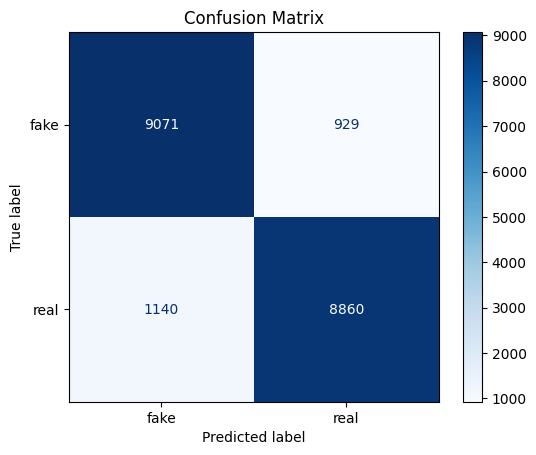


Test Metrics (Enhanced Model):
  Loss:      0.2429
  Accuracy:  0.8965
  Precision: 0.8967
  Recall:    0.8965
  F1-score:  0.8965
  AUC:       0.9643

Enhanced model saved as syntheticSnifferModel.pth


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reload Data (Correct Path) ---
IMAGE_SIZE = 256
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Correct path for the test dataset as defined earlier
test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/test', transform=val_test_transforms) # <<< CORRECTED PATH
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True) # Added pin_memory


# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = HDE(latent_dim=latent_dim, image_size=IMAGE_SIZE) # Instantiate with image_size

# Load the saved state dictionary
model_path = 'syntheticSnifferModel.pth' # Use a new name for the enhanced model
model.load_state_dict(torch.load(model_path, map_location=device)) # Ensure correct device mapping
model.to(device)
model.eval() # Set model to evaluation mode



def evaluate_metrics(model, dataloader, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # For AUC/ROC curve
    running_loss = 0.0  # For calculating average loss

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs) # Model forward pass

            # Compute loss
            loss = criterion(outputs['fused_logits'], labels)
            running_loss += loss.item()

            # Use the fused output for final prediction
            preds = torch.argmax(outputs['fused_logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs['fused_logits'], dim=1)[:, 1].cpu().numpy())  # Probabilities for AUC

    # Compute average loss
    avg_loss = running_loss / len(dataloader)

    # Compute other metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    try:
        # Calculate AUC (using probabilities for AUC)
        auc_value = roc_auc_score(all_labels, all_probs)
    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        auc_value = 0.0

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return avg_loss, acc, prec, rec, f1, auc_value, cm

# --- Run Evaluation ---
criterion = torch.nn.CrossEntropyLoss()  # Define the loss function (same as used during training)
print("Evaluating on Test Set...")
test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, cm = evaluate_metrics(model, test_loader, device, criterion)

# --- Print Test Metrics ---
print("\nTest Metrics (Enhanced Model):")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1-score:  {test_f1:.4f}")
print(f"  AUC:       {test_auc:.4f}")

# --- Save the enhanced model ---
torch.save(model.state_dict(), model_path)
print(f"\nEnhanced model saved as {model_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating on Test Set...


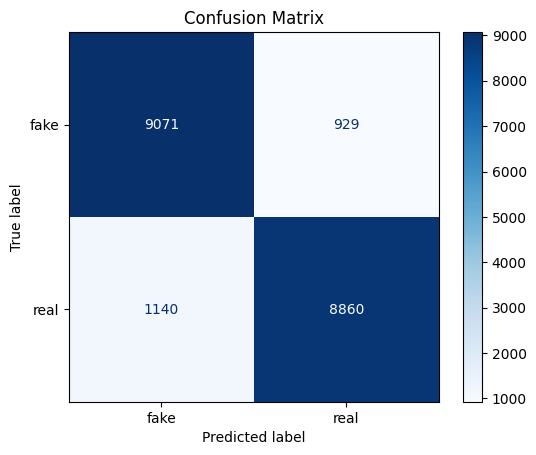


Classification Report:
               precision    recall  f1-score   support

        fake       0.89      0.91      0.90     10000
        real       0.91      0.89      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



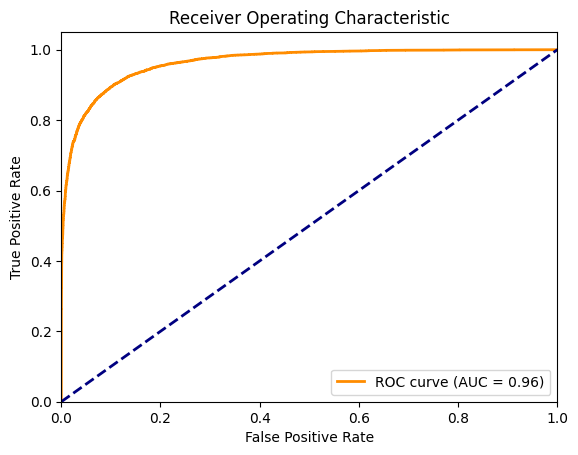


Test Metrics (Enhanced Model):
  Loss:      0.2429
  Accuracy:  0.8965
  Precision: 0.8967
  Recall:    0.8965
  F1-score:  0.8965
  AUC:       0.9643
  MCC:       0.7933

Enhanced model saved as syntheticSnifferModel.pth


In [20]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reload Data (Correct Path) ---
IMAGE_SIZE = 256
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Correct path for the test dataset as defined earlier
test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/test', transform=val_test_transforms) # <<< CORRECTED PATH
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True) # Added pin_memory


# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = HDE(latent_dim=latent_dim, image_size=IMAGE_SIZE) # Instantiate with image_size

# Load the saved state dictionary
model_path = 'syntheticSnifferModel.pth' # Use a new name for the enhanced model
model.load_state_dict(torch.load(model_path, map_location=device)) # Ensure correct device mapping
model.to(device)
model.eval() # Set model to evaluation mode


# --- Evaluation Function ---
def evaluate_metrics(model, dataloader, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # For AUC/ROC curve
    running_loss = 0.0  # For calculating average loss

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs) # Model forward pass

            # Compute loss
            loss = criterion(outputs['fused_logits'], labels)
            running_loss += loss.item()

            # Use the fused output for final prediction
            preds = torch.argmax(outputs['fused_logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs['fused_logits'], dim=1)[:, 1].cpu().numpy())  # Probabilities for AUC

    # Compute average loss
    avg_loss = running_loss / len(dataloader)

    # Compute other metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    try:
        # Calculate AUC (using probabilities for AUC)
        auc_value = roc_auc_score(all_labels, all_probs)
    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        auc_value = 0.0

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(all_labels, all_preds)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(all_labels, all_preds, target_names=test_data.classes)
    print("\nClassification Report:\n", class_report)

    return avg_loss, acc, prec, rec, f1, auc_value, mcc, cm, class_report, all_labels, all_probs

# --- Plot ROC Curve ---
def plot_roc_curve(all_labels, all_probs):
    fpr, tpr, _ = roc_curve(all_labels, all_probs)  # False Positive Rate, True Positive Rate, thresholds
    roc_auc = auc(fpr, tpr)  # Area Under the Curve

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# --- Run Evaluation ---
criterion = torch.nn.CrossEntropyLoss()  # Define the loss function (same as used during training)
print("Evaluating on Test Set...")
test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, test_mcc, cm, class_report, all_labels, all_probs = evaluate_metrics(model, test_loader, device, criterion)

# --- Plot ROC Curve ---
plot_roc_curve(all_labels, all_probs)

# --- Print Test Metrics ---
print("\nTest Metrics (Enhanced Model):")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1-score:  {test_f1:.4f}")
print(f"  AUC:       {test_auc:.4f}")
print(f"  MCC:       {test_mcc:.4f}")

# --- Save the enhanced model ---
torch.save(model.state_dict(), model_path)
print(f"\nEnhanced model saved as {model_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating on Test Set...


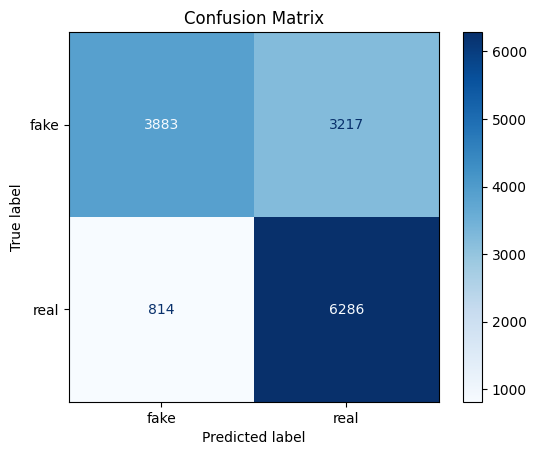


Classification Report:
               precision    recall  f1-score   support

        fake       0.83      0.55      0.66      7100
        real       0.66      0.89      0.76      7100

    accuracy                           0.72     14200
   macro avg       0.74      0.72      0.71     14200
weighted avg       0.74      0.72      0.71     14200



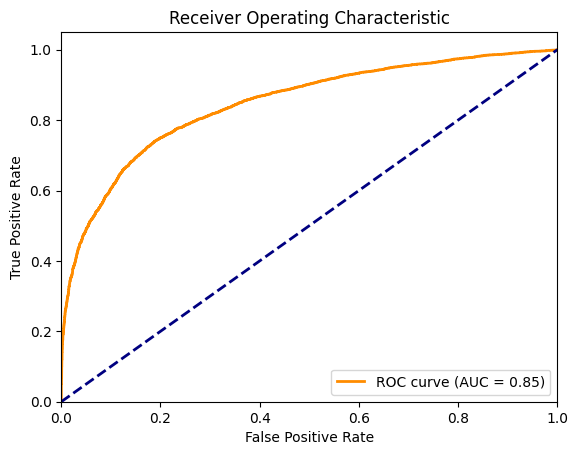


Test Metrics (Enhanced Model):
  Loss:      0.6136
  Accuracy:  0.7161
  Precision: 0.7441
  Recall:    0.7161
  F1-score:  0.7078
  AUC:       0.8459
  MCC:       0.4594

Enhanced model saved as syntheticSnifferModel.pth


In [32]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Reload Data (Correct Path) ---
IMAGE_SIZE = 256
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Correct path for the test dataset as defined earlier
test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/test', transform=val_test_transforms) # <<< CORRECTED PATH
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True) # Added pin_memory


# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = HDE(latent_dim=latent_dim, image_size=IMAGE_SIZE) # Instantiate with image_size

# Load the saved state dictionary
model_path = 'syntheticSnifferModel.pth' # Use a new name for the enhanced model
model.load_state_dict(torch.load(model_path, map_location=device)) # Ensure correct device mapping
model.to(device)
model.eval() # Set model to evaluation mode


# --- Evaluation Function ---
def evaluate_metrics(model, dataloader, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # For AUC/ROC curve
    running_loss = 0.0  # For calculating average loss

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs) # Model forward pass

            # Compute loss
            loss = criterion(outputs['fused_logits'], labels)
            running_loss += loss.item()

            # Use the fused output for final prediction
            preds = torch.argmax(outputs['fused_logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs['fused_logits'], dim=1)[:, 1].cpu().numpy())  # Probabilities for AUC

    # Compute average loss
    avg_loss = running_loss / len(dataloader)

    # Compute other metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    try:
        # Calculate AUC (using probabilities for AUC)
        auc_value = roc_auc_score(all_labels, all_probs)
    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        auc_value = 0.0

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(all_labels, all_preds)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(all_labels, all_preds, target_names=test_data.classes)
    print("\nClassification Report:\n", class_report)

    return avg_loss, acc, prec, rec, f1, auc_value, mcc, cm, class_report, all_labels, all_probs

# --- Plot ROC Curve ---
def plot_roc_curve(all_labels, all_probs):
    fpr, tpr, _ = roc_curve(all_labels, all_probs)  # False Positive Rate, True Positive Rate, thresholds
    roc_auc = auc(fpr, tpr)  # Area Under the Curve

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# --- Run Evaluation ---
criterion = torch.nn.CrossEntropyLoss()  # Define the loss function (same as used during training)
print("Evaluating on Test Set...")
test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, test_mcc, cm, class_report, all_labels, all_probs = evaluate_metrics(model, test_loader, device, criterion)

# --- Plot ROC Curve ---
plot_roc_curve(all_labels, all_probs)

# --- Print Test Metrics ---
print("\nTest Metrics (Enhanced Model):")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall:    {test_rec:.4f}")
print(f"  F1-score:  {test_f1:.4f}")
print(f"  AUC:       {test_auc:.4f}")
print(f"  MCC:       {test_mcc:.4f}")

# --- Save the enhanced model ---
torch.save(model.state_dict(), model_path)
print(f"\nEnhanced model saved as {model_path}")
